# 기초 머신러닝을 통한 시장 예측

 2장에서 트레이딩 전략 설계 방법, 트레이딩 시그널 작성, 트레이딩 자산의 계절성 등 고급 개념의 구현.

 이를 확장하여 Stochastic process, Random walk, Martingale, Time-Series analysis 학습 필요.
 
 이번 장에서는 지도학습 문제에만 초점을 둠. 알고리즘 트레이딩에서 지도학습이 가장 일반적으로 사용됨.

In [1]:
!pip install pandas_datareader
!pip install finance-datareader


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: C:\Users\jh102\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: C:\Users\jh102\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import FinanceDataReader as fdr

start_date = '2001-01-01'
end_date = '2023-01-01'

goog_data = fdr.DataReader('GOOG', start_date, end_date)

In [3]:
'''
Tommorow close_price > Today close_price ==> +1 or -1
when Tommorow close price != Today close price
'''

def create_classification_trading_condition(df):
    df['Open-Close'] = df.Open - df.Close
    df['High-Low'] = df.High - df.Low
    df = df.dropna()
    X = df[['Open-Close', 'High-Low']]
    Y = np.where(df['Close'].shift(-1) > df['Close'], 1, -1)
    return (df, X, Y)

In [4]:
# 가격의 움직임에 따른 부호

def create_regression_trading_condition(df):
    df['Open-Close'] = df.Open - df.Close
    df['High-Low'] = df.High - df.Low
    df['Target'] = df['Close'].shift(-1) - df['Close']
    df = df.dropna()
    X = df[['Open-Close', 'High-Low']]
    Y = df[['Target']]
    return (df, X, Y)

In [5]:
from sklearn.model_selection import train_test_split
# 실제 시장 조건을 잘 대표하지 못하는 훈련/테스트 데이터셋을 방지하는 방법 추가 학습 필요.
def create_train_split_group(X, Y, split_ratio=0.8):
    return train_test_split(X, Y, shuffle=False, train_size=split_ratio)

## 선형회귀 방법을 이용한 예측 모델 구축
OLS > Lasso & Ridge (regulation and shrinkage) > Elastic Net > 결정트리 회귀 순으로 구현

In [6]:
#회귀를 위한 타깃 변수 벡터 Y 생성
goog_data, X, Y = create_regression_trading_condition(goog_data)

array([[<Axes: xlabel='Open-Close', ylabel='Open-Close'>,
        <Axes: xlabel='High-Low', ylabel='Open-Close'>,
        <Axes: xlabel='Target', ylabel='Open-Close'>],
       [<Axes: xlabel='Open-Close', ylabel='High-Low'>,
        <Axes: xlabel='High-Low', ylabel='High-Low'>,
        <Axes: xlabel='Target', ylabel='High-Low'>],
       [<Axes: xlabel='Open-Close', ylabel='Target'>,
        <Axes: xlabel='High-Low', ylabel='Target'>,
        <Axes: xlabel='Target', ylabel='Target'>]], dtype=object)

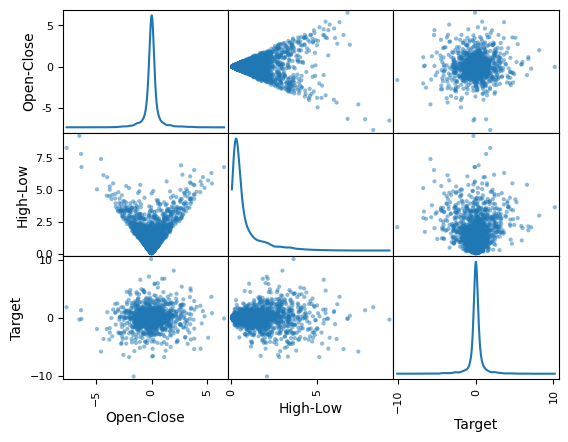

In [7]:
pd.plotting.scatter_matrix(goog_data[['Open-Close','High-Low','Target']],
                           grid=True, diagonal='kde')

In [8]:
# 80% Training set, 20% Test set
X_train,X_test,Y_train,Y_test=create_train_split_group(X,Y,split_ratio=0.8)

In [9]:
from sklearn import linear_model
# Fit the model
ols = linear_model.LinearRegression()
ols.fit(X_train, Y_train)
# Forecast value

LinearRegression()

In [10]:
# The coefficients
print('Coefficients: \n', ols.coef_)

Coefficients: 
 [[ 0.03006278 -0.0196605 ]]


In [11]:
from sklearn.metrics import mean_squared_error, r2_score

#평균 제곱 오차
print("Mean squared error: %.2f" % mean_squared_error(Y_train, ols.predict(X_train)))

#설명된 분산 점수: 1이면 완벽한 예측이다. #모델의 설명력이 아주 낮다.
print('Variance score: %.2f' % r2_score(Y_train, ols.predict(X_train)))

#평균 제곱 오차 #너무 커서 과대 적합의 가능성.
print("Mean squared error: %.2f" % mean_squared_error(Y_test, ols.predict(X_test)))

#설명된 분산 점수: 1이면 완벽한 예측이다.
print('Variance score: %.2f'% r2_score(Y_test, ols.predict(X_test)))

Mean squared error: 0.18
Variance score: 0.00
Mean squred error: 3.84
Variance score: 0.00


In [25]:
goog_data['Predicted_Signal'] = ols.predict(X)
goog_data['GOOG_Returns'] = np.log(
    goog_data['Close'] / goog_data['Close'].shift(1))

print(goog_data.head())

                Open      High       Low     Close  Adj Close     Volume  \
Date                                                                       
2004-08-19  2.490664  2.591785  2.390042  2.499133   2.499133  897427216   
2004-08-20  2.515820  2.716817  2.503118  2.697639   2.697639  458857488   
2004-08-23  2.758411  2.826406  2.716070  2.724787   2.724787  366857939   
2004-08-24  2.770615  2.779581  2.579581  2.611960   2.611960  306396159   
2004-08-25  2.614201  2.689918  2.587302  2.640104   2.640104  184645512   

            Open-Close  High-Low    Target  Predicted_Signal  GOOG_Returns  \
Date                                                                         
2004-08-19   -0.008469  0.201743  0.198506          0.019212           NaN   
2004-08-20   -0.181819  0.213699  0.027148          0.013766      0.076433   
2004-08-23    0.033624  0.110336 -0.112827          0.022275      0.010013   
2004-08-24    0.158655  0.200000  0.028144          0.024271     -0.042289   

In [26]:
def calculate_return(df, split_value, symbol):
    cum_goog_return = df[split_value:]['%s_Returns' % symbol].cumsum() * 100
    df['Strategy_Returns'] = df['%s_Returns' %
                                symbol] * df['Predicted_Signal'].shift(1)
    return cum_goog_return

In [27]:
def calculate_strategy_return(df, split_value, symbol):
    cum_strategy_return = df[split_value:]['Strategy_Returns'].cumsum() * 100
    return cum_strategy_return

In [28]:
cum_goog_return = calculate_return(
    goog_data, split_value=len(X_train), symbol='GOOG')
cum_strategy_return = calculate_strategy_return(
    goog_data, split_value=len(X_train), symbol='GOOG')

In [29]:
import matplotlib.pyplot as plt

def plot_shart(cum_symbol_return, cum_strategy_return, symbol):
    plt.figure(figsize=(10, 5))
    plt.plot(cum_symbol_return, label='%s Returns' % symbol)
    plt.plot(cum_strategy_return, label='Strategy Returns')
    plt.legend()
    plt.show()

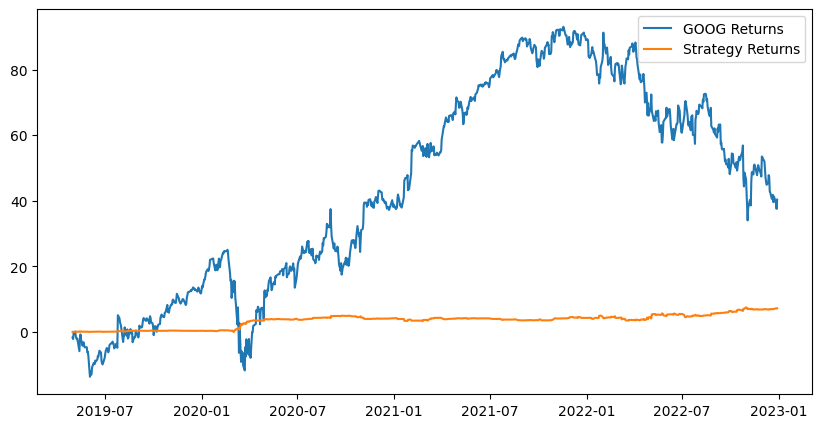

In [30]:
plot_shart(cum_goog_return, cum_strategy_return, symbol='GOOG')

In [31]:
def sharpe_ratio(symbol_returns, strategy_returns):
    strategy_std = strategy_returns.std()
    sharpe = (strategy_returns - symbol_returns) / strategy_std
    return sharpe.mean()

In [32]:
print(sharpe_ratio(cum_strategy_return, cum_goog_return))

1.27436432866127


## 규제 (Regulations)과 축소 (Coefficient Shrinkage), 라쏘Lasso 와 릿지 Ridge

### 라쏘

In [20]:
# 앞부분과 동일한 코드(A) 생략
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import FinanceDataReader as fdr

start_date = '2001-01-01'
end_date = '2023-01-01'

goog_data = fdr.DataReader('GOOG', start_date, end_date)

def load_financial_data(start_date, end_date, output_file):
    try:
        df = pd.read_pickle(output_file)
        print('File data found...reading GOOG data')
    except FileNotFoundError:
        print('File not found...downloading the GOOG data')
        df = data.DataReader('GOOG', 'yahoo', start_date, end_date)
        df.to_pickle(output_file)
    return df

def create_classification_trading_condition(df):
    df['Open-Close'] = df.Open - df.Close
    df['High-Low'] = df.High - df.Low
    df = df.dropna()
    X = df[['Open-Close', 'High-Low']]
    Y = np.where(df['Close'].shift(-1) > df['Close'], 1, -1)
    return (df, X, Y)

def create_regression_trading_condition(df):
    df['Open-Close'] = df.Open - df.Close
    df['High-Low'] = df.High - df.Low
    df['Target'] = df['Close'].shift(-1) - df['Close']
    df = df.dropna()
    X = df[['Open-Close', 'High-Low']]
    Y = df[['Target']]
    return (df, X, Y)

def create_train_split_group(X, Y, split_ratio=0.8):
    return train_test_split(X, Y, shuffle=False, train_size=split_ratio)

goog_data = load_financial_data(
    start_date='2001-01-01',
    end_date='2018-01-01',
    output_file='goog_data_large.pkl')

goog_data, X, Y = create_regression_trading_condition(goog_data)

X_train,X_test,Y_train,Y_test=create_train_split_group(X,Y,split_ratio=0.8)
'''

"\nimport pandas as pd\nimport numpy as np\nimport matplotlib.pyplot as plt\nfrom sklearn.model_selection import train_test_split\nimport FinanceDataReader as fdr\n\nstart_date = '2001-01-01'\nend_date = '2023-01-01'\n\ngoog_data = fdr.DataReader('GOOG', start_date, end_date)\n\ndef load_financial_data(start_date, end_date, output_file):\n    try:\n        df = pd.read_pickle(output_file)\n        print('File data found...reading GOOG data')\n    except FileNotFoundError:\n        print('File not found...downloading the GOOG data')\n        df = data.DataReader('GOOG', 'yahoo', start_date, end_date)\n        df.to_pickle(output_file)\n    return df\n\ndef create_classification_trading_condition(df):\n    df['Open-Close'] = df.Open - df.Close\n    df['High-Low'] = df.High - df.Low\n    df = df.dropna()\n    X = df[['Open-Close', 'High-Low']]\n    Y = np.where(df['Close'].shift(-1) > df['Close'], 1, -1)\n    return (df, X, Y)\n\ndef create_regression_trading_condition(df):\n    df['Open-

In [33]:
from sklearn import linear_model

# Fit the model
lasso = linear_model.Lasso(alpha=0.001) #0.1
lasso.fit(X_train, Y_train)

# The coefficients
print('Coefficients: \n', lasso.coef_)

Coefficients: 
 [ 0.02069422 -0.01146235]


In [34]:
goog_data['Predicted_Signal'] = lasso.predict(X)
goog_data['GOOG_Returns'] = np.log(
    goog_data['Close'] / goog_data['Close'].shift(1))

print(goog_data.head())

                Open      High       Low     Close  Adj Close     Volume  \
Date                                                                       
2004-08-19  2.490664  2.591785  2.390042  2.499133   2.499133  897427216   
2004-08-20  2.515820  2.716817  2.503118  2.697639   2.697639  458857488   
2004-08-23  2.758411  2.826406  2.716070  2.724787   2.724787  366857939   
2004-08-24  2.770615  2.779581  2.579581  2.611960   2.611960  306396159   
2004-08-25  2.614201  2.689918  2.587302  2.640104   2.640104  184645512   

            Open-Close  High-Low    Target  Predicted_Signal  GOOG_Returns  \
Date                                                                         
2004-08-19   -0.008469  0.201743  0.198506          0.017467           NaN   
2004-08-20   -0.181819  0.213699  0.027148          0.013743      0.076433   
2004-08-23    0.033624  0.110336 -0.112827          0.019386      0.010013   
2004-08-24    0.158655  0.200000  0.028144          0.020946     -0.042289   

In [35]:
def calculate_return(df, split_value, symbol):
    cum_goog_return = df[split_value:]['%s_Returns' % symbol].cumsum() * 100
    df['Strategy_Returns'] = df['%s_Returns' %
                                symbol] * df['Predicted_Signal'].shift(1)
    return cum_goog_return

In [36]:
def calculate_strategy_return(df, split_value, symbol):
    cum_strategy_return = df[split_value:]['Strategy_Returns'].cumsum() * 100
    return cum_strategy_return

In [37]:
cum_goog_return = calculate_return(
    goog_data, split_value=len(X_train), symbol='GOOG')
cum_strategy_return = calculate_strategy_return(
    goog_data, split_value=len(X_train), symbol='GOOG')

In [38]:
def plot_shart(cum_symbol_return, cum_strategy_return, symbol):
    plt.figure(figsize=(10, 5))
    plt.plot(cum_symbol_return, label='%s Returns' % symbol)
    plt.plot(cum_strategy_return, label='Strategy Returns')
    plt.legend()
    plt.show()

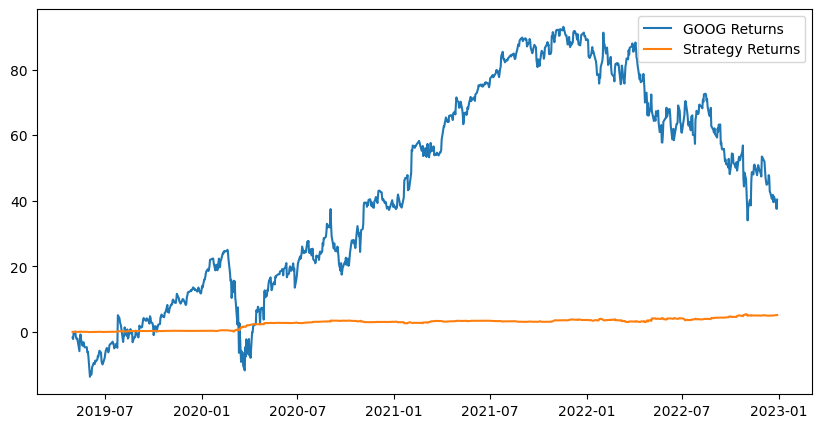

In [39]:
plot_shart(cum_goog_return, cum_strategy_return, symbol='GOOG')

In [40]:
def sharpe_ratio(symbol_returns, strategy_returns):
    strategy_std = strategy_returns.std()
    sharpe = (strategy_returns - symbol_returns) / strategy_std
    return sharpe.mean()

In [41]:
print(sharpe_ratio(cum_strategy_return, cum_goog_return))

1.2987450485791288


In [42]:
from sklearn.metrics import mean_squared_error, r2_score

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(Y_train, lasso.predict(X_train)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y_train, lasso.predict(X_train)))

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(Y_test, lasso.predict(X_test)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y_test, lasso.predict(X_test)))

Mean squared error: 0.18
Variance score: 0.00
Mean squared error: 3.84
Variance score: 0.00


### 릿지

In [43]:
# 앞부분과 동일한 코드(A) 생

ridge = linear_model.Ridge(alpha = 10000)
ridge.fit(X_train, Y_train)

print("Coefficients: \n", ridge.coef_)

Coefficients: 
 [[ 0.00117957 -0.00080595]]


In [44]:
goog_data['Predicted_Signal'] = ridge.predict(X)
goog_data['GOOG_Returns'] = np.log(
    goog_data['Close'] / goog_data['Close'].shift(1))

print(goog_data.head())

                Open      High       Low     Close  Adj Close     Volume  \
Date                                                                       
2004-08-19  2.490664  2.591785  2.390042  2.499133   2.499133  897427216   
2004-08-20  2.515820  2.716817  2.503118  2.697639   2.697639  458857488   
2004-08-23  2.758411  2.826406  2.716070  2.724787   2.724787  366857939   
2004-08-24  2.770615  2.779581  2.579581  2.611960   2.611960  306396159   
2004-08-25  2.614201  2.689918  2.587302  2.640104   2.640104  184645512   

            Open-Close  High-Low    Target  Predicted_Signal  GOOG_Returns  \
Date                                                                         
2004-08-19   -0.008469  0.201743  0.198506          0.015282           NaN   
2004-08-20   -0.181819  0.213699  0.027148          0.015068      0.076433   
2004-08-23    0.033624  0.110336 -0.112827          0.015405      0.010013   
2004-08-24    0.158655  0.200000  0.028144          0.015481     -0.042289   

In [45]:
def calculate_return(df, split_value, symbol):
    cum_goog_return = df[split_value:]['%s_Returns' % symbol].cumsum() * 100
    df['Strategy_Returns'] = df['%s_Returns' %
                                symbol] * df['Predicted_Signal'].shift(1)
    return cum_goog_return

def calculate_strategy_return(df, split_value, symbol):
    cum_strategy_return = df[split_value:]['Strategy_Returns'].cumsum() * 100
    return cum_strategy_return

cum_goog_return = calculate_return(
    goog_data, split_value=len(X_train), symbol='GOOG')
cum_strategy_return = calculate_strategy_return(
    goog_data, split_value=len(X_train), symbol='GOOG')

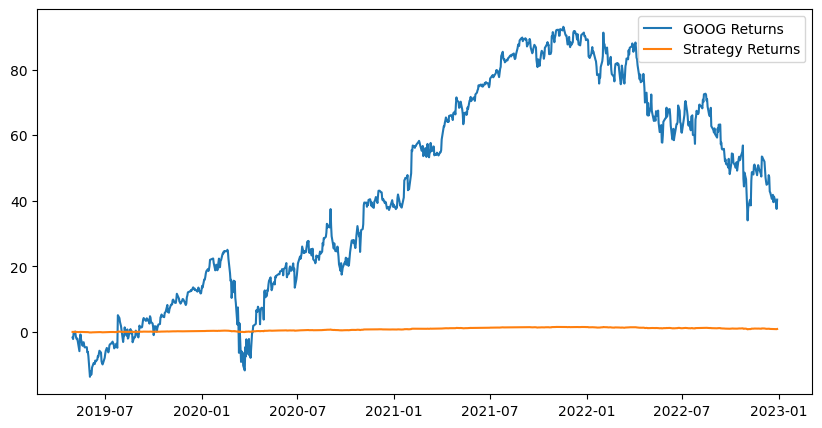

In [46]:
def plot_shart(cum_symbol_return, cum_strategy_return, symbol):
    plt.figure(figsize=(10, 5))
    plt.plot(cum_symbol_return, label='%s Returns' % symbol)
    plt.plot(cum_strategy_return, label='Strategy Returns')
    plt.legend()
    plt.show()

plot_shart(cum_goog_return, cum_strategy_return, symbol='GOOG')

In [47]:
def sharpe_ratio(symbol_returns, strategy_returns):
    strategy_std = strategy_returns.std()
    sharpe = (strategy_returns - symbol_returns) / strategy_std
    return sharpe.mean()


print(sharpe_ratio(cum_strategy_return, cum_goog_return))

1.3580399819964957


In [48]:
from sklearn.metrics import mean_squared_error, r2_score

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(Y_train, ridge.predict(X_train)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y_train, ridge.predict(X_train)))

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(Y_test, ridge.predict(X_test)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y_test, ridge.predict(X_test)))

Mean squared error: 0.18
Variance score: 0.00
Mean squared error: 3.85
Variance score: 0.00


### 결정트리회귀 decision tree regression
결정트리회귀는 앞선 모델들과 달리 비선형에도 적용할 수 있다.

### 선형분류 방법을 이용한 예측 모델
 K- 최근접 이웃 KNN, K-Nearest Neighbors
 서포트 벡터 머신 SVM, Support Vector Machine
 로지스틱 회귀 Logistic Regression

### KNN 알고리즘
지도학습법으로서 비모수 분류기.
새로운 관찰을 k의 가장 유사한 인스턴트와 비교하는 것으로 두 데이터포인트 간의 거리 척도를 정의.

가장 많이 사용되는 것은 유킬리디언 거리 Euclidean distance.

p 파라미터는 거리 유형을 설정.

p=1 이면 맨해튼 거리Manhattan distnace. 두 점 간의 수평과 수직 거리의 합.

p=2 이면 디폴트 값으로서 유클리디언 거리.

p=3 이면 민코브스키 거리 Minkowski distance. 맨해튼과 유클리디언 거리가 일반화된 것.

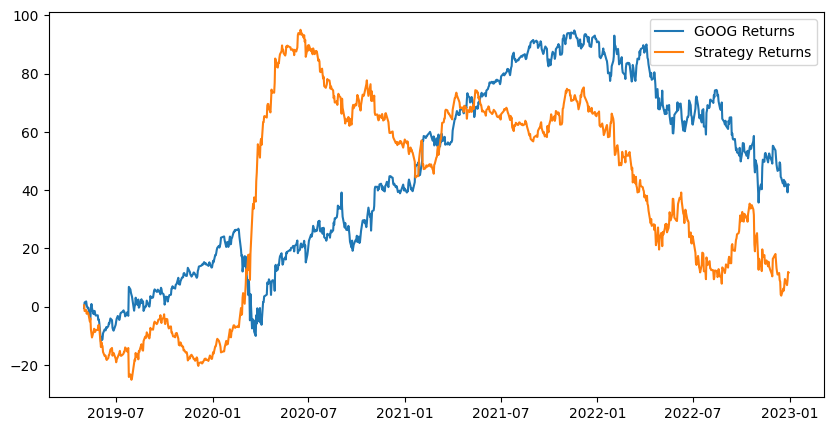

0.22754093009242315


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import FinanceDataReader as fdr

start_date = '2001-01-01'
end_date = '2023-01-01'

goog_data = fdr.DataReader('GOOG', start_date, end_date)


goog_data['Open-Close']=goog_data.Open-goog_data.Close
goog_data['High-Low']=goog_data.High-goog_data.Low
goog_data=goog_data.dropna()
X=goog_data[['Open-Close','High-Low']]
Y=np.where(goog_data['Close'].shift(-1)>goog_data['Close'],1,-1)

split_ratio=0.8
split_value=int(split_ratio * len(goog_data))
X_train=X[:split_value]
Y_train=Y[:split_value]
X_test=X[split_value:]
Y_test=Y[split_value:]


knn=KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, Y_train)
accuracy_train = accuracy_score(Y_train, knn.predict(X_train))
accuracy_test = accuracy_score(Y_test, knn.predict(X_test))




goog_data['Predicted_Signal']=knn.predict(X)
goog_data['GOOG_Returns']=np.log(goog_data['Close']/
                                 goog_data['Close'].shift(1))


def calculate_return(df,split_value,symbol):
    cum_goog_return= df[split_value:]['%s_Returns' % symbol].cumsum() * 100
    df['Strategy_Returns']= df['%s_Returns' % symbol] * df['Predicted_Signal'].shift(1)
    return cum_goog_return

def calculate_strategy_return(df,split_value):
    cum_strategy_return = df[split_value:]['Strategy_Returns'].cumsum() * 100
    return cum_strategy_return

cum_goog_return=calculate_return(goog_data,split_value=len(X_train),symbol='GOOG')
cum_strategy_return= calculate_strategy_return(goog_data,split_value=len(X_train))


def plot_chart(cum_symbol_return, cum_strategy_return, symbol):
    plt.figure(figsize=(10,5))
    plt.plot(cum_symbol_return, label='%s Returns' % symbol)
    plt.plot(cum_strategy_return,label='Strategy Returns')
    plt.legend()
    plt.show()

plot_chart(cum_goog_return, cum_strategy_return,symbol='GOOG')



# print(accuracy_train, accuracy_test)

# goog_data['Predicted_Signal']=knn.predict(X)
# goog_data['GOOG_Returns']=np.log(goog_data['Close']/
#                                  goog_data['Close'].shift(1))
# cum_goog_return=goog_data[split_value:]['GOOG_Returns'].cumsum()*100
#
# goog_data['Strategy_Returns']=goog_data['GOOG_Returns'] * goog_data['Predicted_Signal'].shift(1)
# cum_strategy_return=goog_data[split_value:]['Strategy_Returns'].cumsum()*100
#
# plt.figure(figsize=(10,5))
# plt.plot(cum_goog_return,label='GOOG Returns')
# plt.plot(cum_strategy_return,label='Strategy Returns')
# plt.legend()
# plt.show()


def sharpe_ratio(symbol_returns, strategy_returns):
    strategy_std=strategy_returns.std()
    sharpe=(strategy_returns-symbol_returns)/strategy_std
    return sharpe.mean()

print(sharpe_ratio(cum_strategy_return,cum_goog_return))

### 서포트 벡터 머신 SVM,
지도학슴 머신러닝 방법으로서 데이터를 2개의 클래스로 분리하는 초평면hyperplane을 발견.

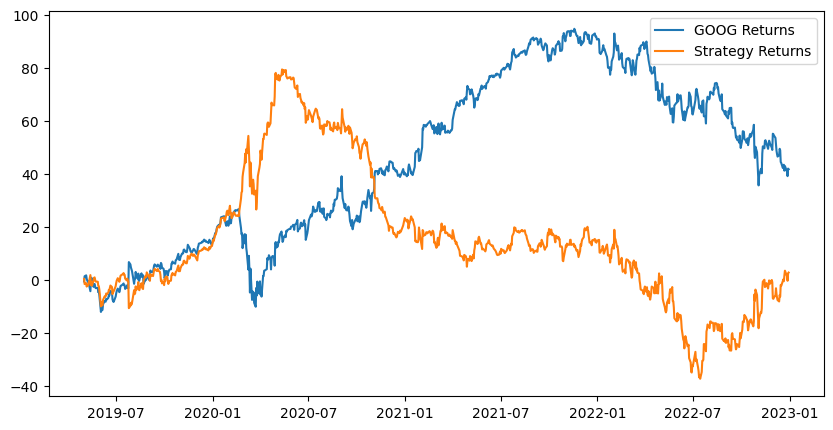

0.5281081081081082 0.4854054054054054
0.9731708632202057


In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import FinanceDataReader as fdr

start_date = '2001-01-01'
end_date = '2023-01-01'

goog_data = fdr.DataReader('GOOG', start_date, end_date)


def create_trading_condition(df):
    df['Open-Close']=df.Open-df.Close
    df['High-Low']=df.High-df.Low
    df=df.dropna()
    X=df[['Open-Close','High-Low']]
    Y=np.where(df['Close'].shift(-1)>df['Close'],1,-1)
    return (X,Y)

def create_train_split_group(X,Y,split_ratio=0.8):
    return train_test_split(X,Y,shuffle=False,train_size=split_ratio)

X,Y=create_trading_condition(goog_data)

X_train,X_test,Y_train,Y_test=\
    create_train_split_group(X,Y,split_ratio=0.8)

# Fit the model
svc=SVC()
svc.fit(X_train, Y_train)
# Forecast value

goog_data['Predicted_Signal']=svc.predict(X)
goog_data['GOOG_Returns']=np.log(goog_data['Close']/
                                 goog_data['Close'].shift(1))


def calculate_return(df,split_value,symbol):
    cum_goog_return= df[split_value:]['%s_Returns' % symbol].cumsum() * 100
    df['Strategy_Returns']= df['%s_Returns' % symbol] * df['Predicted_Signal'].shift(1)
    return cum_goog_return

def calculate_strategy_return(df,split_value):
    cum_strategy_return = df[split_value:]['Strategy_Returns'].cumsum() * 100
    return cum_strategy_return

cum_goog_return=calculate_return(goog_data,split_value=len(X_train),symbol='GOOG')
cum_strategy_return= calculate_strategy_return(goog_data,split_value=len(X_train))


def plot_shart(cum_symbol_return, cum_strategy_return, symbol):
    plt.figure(figsize=(10,5))
    plt.plot(cum_symbol_return, label='%s Returns' % symbol)
    plt.plot(cum_strategy_return,label='Strategy Returns')
    plt.legend()
    plt.show()

plot_shart(cum_goog_return, cum_strategy_return,symbol='GOOG')

def sharpe_ratio(symbol_returns, strategy_returns):
    strategy_std=strategy_returns.std()
    sharpe=(strategy_returns-symbol_returns)/strategy_std
    return sharpe.mean()

accuracy_train = accuracy_score(Y_train, svc.predict(X_train))
accuracy_test = accuracy_score(Y_test, svc.predict(X_test))
print(accuracy_train, accuracy_test)
print(sharpe_ratio(cum_strategy_return,cum_goog_return))

### 로짓 회귀
분류를 위한 지도학습 방법으로서 로짓 시그모이드 logit sigmoid를 이용해 출력을 변환해 상이한 클래스를 매핑하는 확률을 변환.

0.5162162162162162 0.5005405405405405


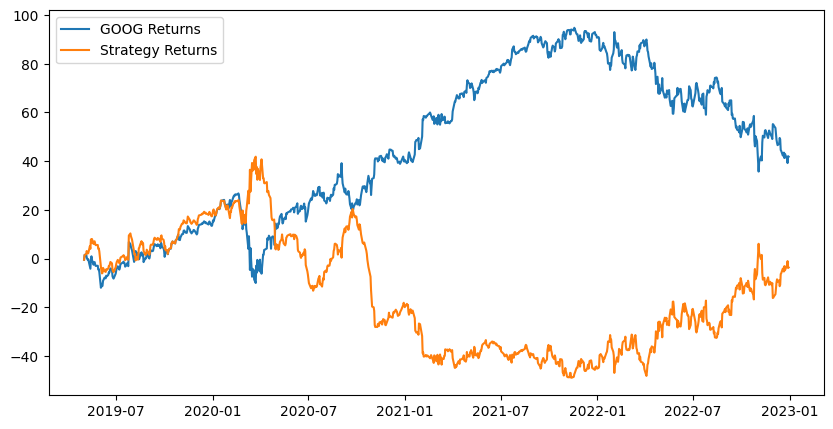

0.5162162162162162 0.5005405405405405
1.904680716523622


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import FinanceDataReader as fdr

start_date = '2001-01-01'
end_date = '2023-01-01'

goog_data = fdr.DataReader('GOOG', start_date, end_date)


goog_data['Open-Close']=goog_data.Open-goog_data.Close
goog_data['High-Low']=goog_data.High-goog_data.Low
goog_data=goog_data.dropna()
X=goog_data[['Open-Close','High-Low']]
Y=np.where(goog_data['Close'].shift(-1)>goog_data['Close'],1,-1)

split_ratio=0.8
split_value=int(split_ratio * len(goog_data))
X_train=X[:split_value]
Y_train=Y[:split_value]
X_test=X[split_value:]
Y_test=Y[split_value:]


logistic=LogisticRegression()
logistic.fit(X_train, Y_train)
accuracy_train = accuracy_score(Y_train, logistic.predict(X_train))
accuracy_test = accuracy_score(Y_test, logistic.predict(X_test))
print(accuracy_train, accuracy_test)


goog_data['Predicted_Signal']=logistic.predict(X)
goog_data['GOOG_Returns']=np.log(goog_data['Close']/goog_data['Close'].shift(1))


def calculate_return(df,split_value,symbol):
    cum_goog_return= df[split_value:]['%s_Returns' % symbol].cumsum() * 100
    df['Strategy_Returns']= df['%s_Returns' % symbol] * df['Predicted_Signal'].shift(1)
    return cum_goog_return

def calculate_strategy_return(df,split_value):
    cum_strategy_return = df[split_value:]['Strategy_Returns'].cumsum() * 100
    return cum_strategy_return

cum_goog_return=calculate_return(goog_data,split_value=len(X_train),symbol='GOOG')
cum_strategy_return= calculate_strategy_return(goog_data,split_value=len(X_train))


def plot_shart(cum_symbol_return, cum_strategy_return, symbol):
    plt.figure(figsize=(10,5))
    plt.plot(cum_symbol_return, label='%s Returns' % symbol)
    plt.plot(cum_strategy_return,label='Strategy Returns')
    plt.legend()
    plt.show()

plot_shart(cum_goog_return, cum_strategy_return,symbol='GOOG')

def sharpe_ratio(symbol_returns, strategy_returns):
    strategy_std=strategy_returns.std()
    sharpe=(strategy_returns-symbol_returns)/strategy_std
    return sharpe.mean()

accuracy_train = accuracy_score(Y_train, logistic.predict(X_train))
accuracy_test = accuracy_score(Y_test, logistic.predict(X_test))
print(accuracy_train, accuracy_test)
print(sharpe_ratio(cum_strategy_return,cum_goog_return))


#                                  goog_data['Close'].shift(1))
# cum_goog_return=goog_data[split_value:]['GOOG_Returns'].cumsum()*100
#
# goog_data['Strategy_Returns']=goog_data['GOOG_Returns'] * goog_data['Predicted_Signal'].shift(1)
# cum_strategy_return=goog_data[split_value:]['Strategy_Returns'].cumsum()*100
#
# plt.figure(figsize=(10,5))
# plt.plot(cum_goog_return,label='GOOG Returns')
# plt.plot(cum_strategy_return,label='Strategy Returns')
# plt.legend()
# plt.show()
#
#
# def sharpe_ratio(symbol_returns, strategy_returns):
#     strategy_std=strategy_returns.std()
#     sharpe=(strategy_returns-symbol_returns)/strategy_std
#     return sharpe.mean()
#
# print(sharpe_ratio(cum_strategy_return,cum_goog_return))